# Download Dataset
- Download dataset from Box
- Decompress dataset
- The wafer map dataset is the same as the last homework

In [ ]:
!wget -nc -O datasets.zip https://ucsb.box.com/shared/static/vz9pmd1h7eexf2qxr5odvjy0xew5aqpo.zip

In [ ]:
!unzip -n datasets.zip

# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import pandas as pd
from typing import Dict, Final, List, Tuple, NamedTuple, Type
from tqdm.auto import tqdm, trange

import cv2

from collections import Counter

import matplotlib.pyplot as plt

# TODO: Type = NotImplemented

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)


PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


# Type Definition
Define some types for clearer labeling of our interfaces.

In [2]:
# TODO = NotImplemented  # NOTE: This is a placeholder for code that needs to be written

Loss: Type = float
Accuracy: Type = float


class LossAcc(NamedTuple):
    loss: Loss
    accuracy: Accuracy


class TrainValLossAcc(NamedTuple):
    train: List[List[LossAcc]]
    val: List[LossAcc]


example_result_pair: LossAcc = LossAcc(1.6, 0.7)
print("loss:", example_result_pair.loss)
print("accuracy:", example_result_pair.accuracy)
print(example_result_pair)

loss: 1.6
accuracy: 0.7
LossAcc(loss=1.6, accuracy=0.7)


Load training data from the training pickle file.

In [3]:
# load training data from pickle file
# assign the training data pickle file path
train_pickle ='datasets/datasets/WM811K/train/wafermap_train.npy'# CODE HERE
df_train: pd.DataFrame = pd.DataFrame.from_records(
    np.load(train_pickle, allow_pickle=True)
)

# Configurations
Some configuration options that are required to make the dataset work with PyTorch.

In [4]:
classes: Final[List[str]] = df_train.failureType.unique()

num_classes: Final[int] = len(classes)

num_epochs: Final[int] = 20

batch_size: Final[int] = 16

valid_set_size: Final[float] = 0.30

NO_DIE: Final[int] = 0
PASS_DIE: Final[int] = 1
FAIL_DIE: Final[int] = 2
NUM_DIE_STATES: Final[int] = 3


print("Number of classes: ", num_classes)
print("Number of epochs: ", num_epochs)
print("Batch size: ", batch_size)


Number of classes:  5
Number of epochs:  20
Batch size:  16


Functions for
- converting the failure type from string to int
- resizing the wafer map and converting it into a 3-channel image

In [5]:
def convert_failure_type(failure_type: str) -> int:
    # Create dictionary for converting string to numeric number
    string2int: Final[Dict[str, int]] = {class_name: i for i, class_name in enumerate(classes)}

    return string2int[failure_type]


def resize_wafer_map(
    wafer_map: np.ndarray, output_shape: tuple = (64, 64)
) -> np.ndarray:
    # Final shape should be (3, 64, 64) for VGG16.
    # To get the color dimension, we have many options:
    #   + one-hot encode the integer labels
    #   + use the MatPlotLib color map
    #   + encode meaningful feature information
    # Feel free to explore other options; you do not need to keep this given code!
    resized = cv2.resize(wafer_map, output_shape, interpolation=cv2.INTER_NEAREST)
    ret = np.eye(NUM_DIE_STATES)[resized]
    ret = ret.transpose(2, 1, 0)  # (3, 64, 64)
    return ret


# Wafer Dataset Class
The easiest way to work with PyTorch is to use its `Dataset` utility class. This class is used to load and wrap datapoints in PyTorch `tensor` objects, which are used to represent data in a device-specific way in PyTorch. `tensor`s allow for neural network training on GPUs.

We provide the partial implementation of the wafer dataset below. You can see that it inherits from the `Dataset` class, and implements the `__len__` and `__getitem__` methods. The `__len__` method returns the number of datapoints in the dataset, and the `__getitem__` method returns a datapoint at a given index.

In [6]:
class WaferDataset(torch.utils.data.Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 size: Tuple[int,int]=(64,64),
                 no_label: bool = False
                 ):
        self.df = df
        self.size = size
        self.no_label = no_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.df.loc[idx, "waferMap"]
        # Use your resize_wafer_map function to resize the wafer map
        img = resize_wafer_map(img, output_shape=self.size) # CODE HERE
        img = img.astype("float32")
        img = torch.from_numpy(img)

        if(self.no_label):
          label = torch.nan
        else:
          label = self.df.loc[idx, "failureType"]
          # Use your convert_failure_type function to convert the failure type
          label = convert_failure_type(label) # CODE HERE
          label = torch.tensor(label)
        return img, label

In [7]:
all_dataset = WaferDataset(df_train, size=(64,64))

PyTorch provides the `torch.utils.data.random_split()` function to split a dataset. This method takes a dataset and a list of lengths/ratios, and returns a list of datasets of the specified lengths/ratios. If lengths are given, the sum of the lengths must equal the length of the original dataset. If ratios are given, the sum of the ratios must equal to 1. In the configuration block above, we have already computed `valid_set_size` for you, so you can use it to create a train/valid split.

To get a consistent split, you are able to set your own random seed, though the process is more complex than for `scikit-learn`. To do so, add the argument `generator=torch.Generator().manual_seed(9)` to the `random_split()` function call. This split has produced a good class balance in our testing, but you are welcome to experiment with different `valid_set_size` and `manual_seed` values.

In [8]:
train_size = int((1 - valid_set_size) * len(all_dataset))
val_size = len(all_dataset) - train_size
generator = torch.Generator().manual_seed(9)
train_dataset, val_dataset = random_split(all_dataset, [train_size, val_size]) # CODE HERE


Once arranged into a `Dataset`, we wrap the `Dataset` in a `Dataloader` object. This object is used to iterate over the dataset in batches, shuffle the dataset, and perform other useful operations, like parallel data loading.

In [9]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              pin_memory=True
                              )
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            pin_memory=True                           
                            )

The below visualization of class label balances is provided for your reference. The train/valid split should produce similar class label balances.

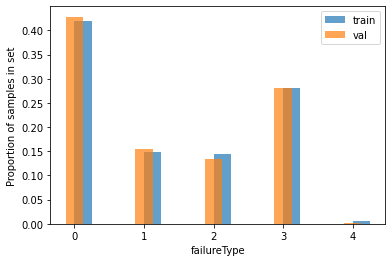

In [11]:
train_labels = pd.DataFrame(
    Counter(l.item() for _, l in train_dataset).items(),
    columns=["failureType", "count"],
)
val_labels = pd.DataFrame(
    Counter(l.item() for _, l in val_dataset).items(), columns=["failureType", "count"]
)
train_labels["train"] = True
train_labels["ratio"] = train_labels["count"] / (train_labels["count"].sum())
val_labels["train"] = False
val_labels["ratio"] = val_labels["count"] / (val_labels["count"].sum())
labels = pd.concat([train_labels, val_labels])

plt.bar(
    labels[labels["train"]]["failureType"],
    labels[labels["train"]]["ratio"],
    label="train",
    alpha=0.7,
    width=0.25,
    align="edge",
)
plt.bar(
    labels[~labels["train"]]["failureType"],
    labels[~labels["train"]]["ratio"],
    label="val",
    alpha=0.7,
    width=0.25,
)
plt.legend()
plt.xlabel("failureType")
plt.ylabel("Proportion of samples in set")
plt.show()


# Custom Neural Network
Now we'll define a new network. We'll use this network to train on the wafer dataset. We'll use the `torch.nn` module to define the network. This module provides a number of useful building blocks for neural networks, including linear layers, convolution layers, dropout layers, maxpooling layers, activation functions, flatten function, and loss functions.

We want a model with the following layers:
+ Convolutional Layer 1: Input has 3 channels, output has 32 channels, kernel size is 3x3, and padding is 1.
+ ReLU activation is applied.
+ Dropout is applied with a probability of 0.5.
+ Max-Pooling Layer 1: Performs max-pooling with a kernel size of 2x2 and a stride of 2.
+ Convolutional Layer 2: Input has 32 channels, output has 64 channels, kernel size is 3x3, and padding is 1.
+ ReLU activation is applied.
+ Dropout is applied with a probability of 0.5.
+ Max-Pooling Layer 2: Performs max-pooling with a kernel size of 2x2 and a stride of 2.
+ Flatten layer is applied.
+ Fully Connected Layer 1: Input size is 64\*16\*16, output size is 128.
+ ReLU activation is applied.
+ Dropout is applied with a probability of 0.5.
+ Fully Connected Layer 2: Input size is 128, output size is 5 (for 5 output classes).


If this is your absolute first interaction with PyTorch, you may find [this basic tutorial link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) and [this CNN tutorial link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network) to be of use.

In [10]:
class WaferNetwork(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(WaferNetwork, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 5)

        # Define dropout layers with the given dropout probability
        self.dropout_conv = nn.Dropout2d(p=dropout_prob)
        self.dropout_fc = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout_conv(x)  # Apply dropout to the output of the first convolutional layer
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.dropout_conv(x)  # Apply dropout to the output of the second convolutional layer
        x = self.pool(x)

        # Flatten the tensor before passing it through fully connected layers
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout to the output of the first fully connected layer
        x = self.fc2(x)

        return x

# Create an instance of the WaferNetwork model with dropout
model = WaferNetwork(dropout_prob=0.3)

# Validate Function

We will define the `validate` function that evaluates the performance of the model after every training epoch. This function simply puts the network into `eval` mode, then iterates over the dataset and computes the accuracy and loss of the network.

Accuracy computations you can perform in similar manner as you have in the past assignments. For loss computations, we will use the `torch.nn.functional.cross_entropy` function, which assumes the network outputs class logits, and computes the cross entropy loss between the logits and the ground truth labels.

Some components of models behave differently whether they're under training or validation. For example, dropout layers will randomly drop out nodes during training, but will not do so during validation. To handle this, PyTorch provides the `.train()` method to set the model into training mode and the `.eval()` method to set the model into validation mode. We will use this to set the model into validation mode before computing the accuracy and loss.

Running data through a model is as simple as treating the model as a function! That is, `model(data)` will run the data through the model and return the output. We can then use this output to compute the accuracy and loss.

The result of `torch.tensor` computations is always more `torch.tensor`s, so use the `.item()` method to get the actual value of the loss and/or accuracy when you are ready to store it.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [11]:
def validate(model: nn.Module, val_data: DataLoader) -> LossAcc:
    """
    Returns the loss and accuracy of the model on the validation data.
    """
    # Check for GPU availability:
    # This code assigns the GPU ("cuda") as the device if a GPU is available;
    # otherwise, it defaults to the CPU.
    # Hint: search for `torch.device` and `torch.cuda.is_available`
    # Hint: You should be able to code this in one line.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# CODE HERE

    # Move the model to the GPU using the `.to` method
    # Hint: This is a single method call.
    # CODE HERE (One line)
    model = model.to(device)
    # Set model to evaluation mode
    # Hint: This is a single method call.
    # CODE HERE (One line)
    model.eval()
    # The below line sets up an environment that prevents
    # the model from updating its weights during validation.
    # This is helpful because we don't want to update the weights,
    # so using this line saves us expensive gradient computations.
    with torch.no_grad():
        # Set up any tracking variables you'd like to use in order to compute
        # the accuracy and average loss over all batches
        # CODE HERE
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        # Iterate through the batches of validation data
        # CODE HERE
        for data, labels in val_data:

            # Get the data and labels from the batch
            # CODE HERE
            data, labels = data.to(device), labels.to(device)

            # Move the data and labels to the GPU using the `.to` method
            # CODE HERE
            outputs = model(data)

            # Get the model's predictions for the data
            # CODE HERE
            outputs = model(data)
            # Calculate the average loss of this batch
            # using `nn.functional.cross_entropy`
            # CODE HERE
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()
            # Calculate the number of correct predictions and
            # retrieve the number of samples in this batch
            # CODE HERE
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        # Compute the accuracy and average loss over all batches.
        accuracy = correct_predictions / total_samples# CODE HERE
        average_loss = total_loss / len(val_data)# CODE HERE

        return LossAcc(loss=average_loss, accuracy=accuracy)

# Training Functions

Now, to train a model, we have to write training functions. To ease understanding, we've broken the writing of a "training loop" into three functions: `train_batch` to handle a single batch, `train_epoch` to handle a single epoch, and `train_loop` to handle training as many steps as you would like.

Remember, we're still using `nn.functional.cross_entropy` to compute the loss. Don't forget to set the model to `.train()` mode before training!

After setting the model to training, we need to zero out the gradients from the previous step. This is because PyTorch accumulates gradients from each step, and we don't want to accumulate multiple steps of gradients after we've already used their gradients to update the model. We can zero out the gradients by calling the `.zero_grad()` method on the optimizer. Once we've computed the loss, we can call the `.backward()` method on the loss to compute the gradients. Finally, we can call the `.step()` method on the optimizer to update the model weights.

To leverage a GPU for speeding up the computation, you should move the model, data, and labels to the GPU when a GPU is available.

In [12]:
def train_batch(
    model: nn.Module,
    optimizer: optim.Optimizer,
    inputs: torch.Tensor,
    labels: torch.Tensor,
) -> LossAcc:
    """
    Trains the model on a single batch of data.
    Returns the loss and accuracy of the model on the batch.
    """

    # Set model to training mode
    # CODE HERE (One line)
    model.train()
    # Zero the gradients
    # CODE HERE (One line)
    optimizer.zero_grad()
    # Get the model's predictions for the data
    # CODE HERE (One line)
    outputs = model(inputs)
    # Calculate the loss using `nn.functional.cross_entropy`
    # CODE HERE (One line)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Backpropagate the loss using `backward` method
    # CODE HERE (One line)
    loss.backward()

    # Update the model's weights using `step` method
    # CODE HERE (One line)
    optimizer.step()

    with torch.no_grad():
        # Calculate the accuracy
        # CODE HERE
        _, predicted = torch.max(outputs, 1)
        correct_predictions = (predicted == labels).sum().item()
        accuracy = correct_predictions / labels.size(0)
        # Return the loss and accuracy
        return LossAcc(loss.item(), accuracy)


def train_epoch(
    model: nn.Module, optimizer: optim.Optimizer, train_data: DataLoader
) -> List[LossAcc]:
    """
    Trains the model on a single epoch of data.
    Returns a list of the loss and accuracy of the model on each batch.
    """
    # Check for GPU availability:
    # This code assigns the GPU ("cuda") as the device if a GPU is available;
    # otherwise, it defaults to the CPU.
    # Hint: search for `torch.device` and `torch.cuda.is_available`
    # Hint: You should be able to code this in one line.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CODE HERE

    # Move the model to the GPU using the `.to` method
    # CODE HERE (One line)
    model = model.to(device)

    # Set up a list to store the LossAcc (loss and accuracy) of the batches
    # CODE HERE
    batch_losses = []

    # Iterate through the batches of training data
    # CODE HERE
    for inputs, labels in train_data:

        # Get the data and labels from the batch
        # CODE HERE
        inputs, labels = inputs.to(device), labels.to(device)

        # Move the data and labels to the GPU using the `.to` method
        # CODE HERE

        # Train the model on the batch with `train_batch`
        # CODE HERE
        loss_acc = train_batch(model, optimizer, inputs, labels)

        # Add the LossAcc to the list
        # CODE HERE
        batch_losses.append(loss_acc)

    # Return the list of LossAcc
    # CODE HERE
    return batch_losses


def train_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    train_data: DataLoader,
    val_data: DataLoader,
    num_epochs: int = 10,
) -> TrainValLossAcc:
    """
    Trains the model on the training data for `num_epochs` epochs.
    Returns the loss and accuracy of the model on the training and validation data,
    taken per-batch in training and per-epoch in validation.
    """
    # Set up a list to store the lists of training List[LossAcc]
    # and another list to store the validation LossAcc
    # CODE HERE
    train_losses = []
    val_losses = []
    # Initialize variables to track the best model's state dictionary and
    # best validation loss
    # CODE HERE
    best_model_wts = model.state_dict()
    best_val_loss = float('inf')
    # Iterate through the epochs
    for epoch in tqdm(range(num_epochs), desc='Training progress...'):

        # Train the model on the epoch with `train_epoch`
        # CODE HERE
        train_batch_losses = train_epoch(model, optimizer, train_data)

        # Validate the model on the validation data
        # CODE HERE
        val_loss_acc = validate(model, val_data)

        # Add the loss and accuracy to the lists
        # CODE HERE
        train_losses.append(train_batch_losses)
        val_losses.append(val_loss_acc)
        # Update best model's state dictionary and best validation loss
        # if validation loss is lower than the best validation loss
        # CODE HERE
        if val_loss_acc.loss < best_val_loss:
            best_val_loss = val_loss_acc.loss
            best_model_wts = model.state_dict()
    # Load the model state dictionary with the best model's state dictionary
    # CODE HERE
    model.load_state_dict(best_model_wts)

    # Return the lists of loss and accuracy
    return TrainValLossAcc(
        train=train_losses,
        val=val_losses
    )


# Train Custom Neural Network

Finally, we can train your first neural network! We'll use basic Stochastic Gradient Descent (SGD) as the optimization routine to train the network. We'll use a learning rate of 0.1, and train for 20 epochs, to give the model a good chance of success.

In [13]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
history: TrainValLossAcc = train_loop(
    model=model,
    optimizer=optimizer,
    train_data=train_dataloader,  
    val_data=val_dataloader,     
    num_epochs=20          
)    # CODE HERE

Training progress...:   0%|          | 0/20 [00:00<?, ?it/s]

We provide this visualization code, to give you a picture of what your model learned while it was training.

In [14]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


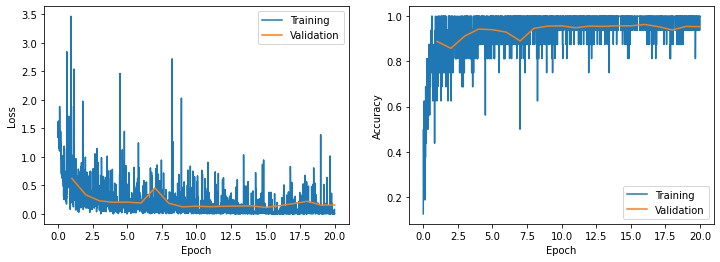

In [15]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [16]:
best_train_accuracy = training_history['accuracy'].max()*100
print(f'Best training accuracy: {best_train_accuracy:.2f}%')
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()*100
print(f'Best validation accuracy during training: {best_accuracy:.2f}%')
from torchsummary import summary
summary(model, input_size=(3, 64, 64))
print(model)

Best training accuracy: 100.00%
Best validation accuracy during training: 95.75%
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         Dropout2d-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
         Dropout2d-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Linear-7                  [-1, 128]       2,097,280
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 5]             645
Total params: 2,117,317
Trainable params: 2,117,317
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.38
Params size (

# Test Data Prediction: Custom Neural Network Model
Make Predictions for the Test Data. This function is already defined for you, you just need to call it and pass in the required parameters.

In [21]:
def generate_test_predictions(model: WaferNetwork,
                              test_pickle: str,
                              output_csv_path: str,
                              classes: List[str],
                              ):
    # load test dataframe from pickle
    df_test: pd.DataFrame = pd.DataFrame.from_records(
        np.load(test_pickle, allow_pickle=True)
    )

    # Create a DataLoader for the test dataset
    test_dataset = WaferDataset(df_test, size=(64,64), no_label=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load the pre-trained model
    model.eval()

    # Initialize a list to store the predicted class labels
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Convert integer labels to class names
            predicted_class_names = [classes[p] for p in predicted]

            # predicted class labels
            predicted_labels.extend(predicted_class_names)

    # Create a DataFrame to store basenames and predicted labels
    data = {'Predictions': predicted_labels}
    df = pd.DataFrame(data)

    # Save the sorted predictions to a CSV file
    df.to_csv(output_csv_path, index=False)
    print(f'Predictions saved to {output_csv_path}')

In [18]:
# Generate test predictions and output the predictions to CSV named 'wafermap_custom_nn_prediction.csv'
generate_test_predictions(
    model = model,# CODE HERE
    test_pickle = 'datasets/datasets/WM811K/test/wafermap_test.npy',# CODE HERE
    output_csv_path = 'wafermap_custom_nn_prediction.csv',# CODE HERE
    classes = classes # CODE HERE
)

Predictions saved to wafermap_custom_nn_prediction.csv


# Fine-Tune VGG16

Now, we will be fine-tuning a VGG16 model to perform the same wafer classification task and compare the performance against the previous model which is trained from scratch.

Overview of Fine-Tuning VGG16

VGG16 is a popular deep convolutional neural network architecture used for various computer vision tasks. It consists of two main components: the "features" part and the "classifier" part. Fine-tuning VGG16 involves adjusting these components to adapt the pre-trained model to a new task.

Components of VGG16
1. Features Layers:
The "features" part of VGG16 comprises a stack of convolutional and max-pooling layers. These layers serve as feature extractors and are responsible for capturing hierarchical features from the input image.
These layers are typically frozen during fine-tuning. Freezing means that the weights of these layers are not updated during training to preserve the pre-trained knowledge.
2. Classifier Layers:
The "classifier" part of VGG16 consists of fully connected layers (also known as dense layers). These layers are responsible for making predictions based on the extracted features.
During fine-tuning, the classifier layers are often replaced by a new set of fully connected layers to adapt the model to the specific task.
---

Load the Pre-Trained VGG16 Model:

Begin by loading the pre-trained VGG16 model with weights 'IMAGENET1K_V1', which includes both the features and classifier components. You can do this using PyTorch's torchvision.models.

In [7]:
import torchvision.models as models

# load VGG16 models with weights 'IMAGENET1K_V1'
# CODE HERE
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) # CODE HERE


Freeze the Features Layers:

Disable gradient updates to prevent them from changing during training. This step ensures that the model retains its ability to extract relevant features from the data.

In [8]:
# Get the features part of the model
features = model.features # CODE HERE

# Freeze the feature layers
# CODE HERE
for param in features.parameters():
    param.requires_grad = False

Define and Replace the Classifier:

+ Replace only the last layer to have 5 output units for the wafer dataset. Note: Last classifier layer has 4096 input units.
+ Set the last layer to require gradients for fine-tuning.

In [9]:
# Modify the last layer to have 5 output units for the wafer dataset
# CODE HERE
num_classes = 5
model.classifier[6] = nn.Linear(4096, num_classes)

# Set the last layer to require gradients for fine-tuning
# CODE HERE
model.classifier[6].requires_grad = True

# Create Dataset (VGG16)
VGG16 is pre-trained on (224, 224) image size so we need to recreate the dataset and data loader with wafermaps resized to that size.

In [10]:
# Redefine the `all_dataset` with size = (224, 224)
all_dataset = WaferDataset(df_train, size=(224, 224)) # CODE HERE

# Split the dataset into training and validation with the same configuration as above
# CODE HERE
train_size = int((1 - valid_set_size) * len(all_dataset))
val_size = len(all_dataset) - train_size
generator = torch.Generator().manual_seed(9)
train_dataset, val_dataset = random_split(all_dataset, [train_size, val_size]) # CODE HERE

# Create the data loader with the same configuration as above
# CODE HERE
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # CODE HERE

Fine-Tuning VGG16

In [20]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

def setup_vgg16_for_finetuning(num_classes=5, learning_rate=0.0001):
    # 1. Load model with pretrained weights
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    
    # 2. Freeze most layers but unfreeze a few last convolutional layers
    # This allows some feature adaptation while maintaining pretrained knowledge
    for param in model.features[:20].parameters():  # Freeze first 20 layers
        param.requires_grad = False
    for param in model.features[20:].parameters():  # Unfreeze last few conv layers
        param.requires_grad = True
    
    # 3. Modify classifier with proper initialization
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 2048),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(2048, num_classes)
    )
    
    # 4. Initialize the new layers
    for m in model.classifier.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    # 5. Set up optimizer with different learning rates for different parts
    # Higher learning rate for new layers, lower for fine-tuned layers
    params_to_update = []
    params_to_update_classifier = []
    
    for name, param in model.named_parameters():
        if param.requires_grad and "classifier" not in name:
            params_to_update.append(param)
        elif param.requires_grad and "classifier" in name:
            params_to_update_classifier.append(param)
    
    optimizer = optim.AdamW([
        {'params': params_to_update, 'lr': learning_rate},
        {'params': params_to_update_classifier, 'lr': learning_rate * 10}
    ])
    
    # 6. Set up learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        verbose=True
    )
    
    return model, optimizer, scheduler

In [23]:
# VGG16 Train loop
def train_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    scheduler,
    train_data: DataLoader,
    val_data: DataLoader,
    num_epochs: int = 10,
) -> TrainValLossAcc:
    """
    Trains the model on the training data for `num_epochs` epochs.
    Returns the loss and accuracy of the model on the training and validation data,
    taken per-batch in training and per-epoch in validation.
    """
    # Set up a list to store the lists of training List[LossAcc]
    # and another list to store the validation LossAcc
    # CODE HERE
    train_losses = []
    val_losses = []
    # Initialize variables to track the best model's state dictionary and
    # best validation loss
    # CODE HERE
    best_model_wts = model.state_dict()
    best_val_loss = float('inf')
    # Iterate through the epochs
    for epoch in tqdm(range(num_epochs), desc='Training progress...'):

        # Train the model on the epoch with `train_epoch`
        # CODE HERE
        train_batch_losses = train_epoch(model, optimizer, train_dataloader)

        # Validate the model on the validation data
        # CODE HERE
        val_loss_acc = validate(model, val_dataloader)
        scheduler.step(val_loss_acc.loss)
        # Add the loss and accuracy to the lists
        # CODE HERE
        train_losses.append(train_batch_losses)
        val_losses.append(val_loss_acc)
        # Update best model's state dictionary and best validation loss
        # if validation loss is lower than the best validation loss
        # CODE HERE
        if val_loss_acc.loss < best_val_loss:
            best_val_loss = val_loss_acc.loss
            best_model_wts = model.state_dict()
    # Load the model state dictionary with the best model's state dictionary
    # CODE HERE
    model.load_state_dict(best_model_wts)

    # Return the lists of loss and accuracy
    return TrainValLossAcc(
        train=train_losses,
        val=val_losses
    )

# Fine-Tune VGG16 Model

In [14]:
# Create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
history: TrainValLossAcc = train_loop(
    model=model,
    optimizer=optimizer,
    train_data=train_dataloader,
    val_data=val_dataloader,
    num_epochs=20
)# CODE HERE


Training progress...:   0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
model, optimizer, scheduler = setup_vgg16_for_finetuning(num_classes=5)
# Train the model
history: TrainValLossAcc = train_loop(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_data=train_dataloader,  
    val_data=val_dataloader,     
    num_epochs=20          
)  

Training progress...:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00005: reducing learning rate of group 1 to 5.0000e-04.
Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.
Epoch 00009: reducing learning rate of group 1 to 2.5000e-04.
Epoch 00013: reducing learning rate of group 0 to 1.2500e-05.
Epoch 00013: reducing learning rate of group 1 to 1.2500e-04.
Epoch 00017: reducing learning rate of group 0 to 6.2500e-06.
Epoch 00017: reducing learning rate of group 1 to 6.2500e-05.


We provide this visualization code, to give you a picture of what your model learned while it was training.

In [15]:
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields,
)
training_history["epoch"] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(history.val, columns=LossAcc._fields)
validation_history["epoch"] = validation_history.index + 1


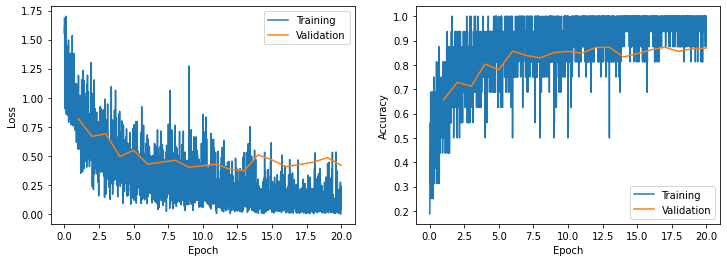

In [16]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history["epoch"], training_history["loss"], label="Training")
ax[0].plot(validation_history["epoch"], validation_history["loss"], label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(training_history["epoch"], training_history["accuracy"], label="Training")
ax[1].plot(
    validation_history["epoch"], validation_history["accuracy"], label="Validation"
)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [22]:
best_train_accuracy = training_history['accuracy'].max()*100
print(f'Best training accuracy: {best_train_accuracy:.2f}%')
# Get the validation accuracy of the best model
# Get the accuracy corresponding to the lowest loss
lowest_loss = validation_history['loss'].min()
best_accuracy = validation_history.loc[validation_history['loss'] == lowest_loss, 'accuracy'].item()*100
print(f'Best validation accuracy during training: {best_accuracy:.2f}%')
from torchsummary import summary
summary(model, input_size=(3, 224, 224))
print(model)

Best training accuracy: 100.00%
Best validation accuracy during training: 87.26%


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Test Data Prediction: VGG16

In [18]:
# Generate test predictions and output the predictions to CSV named 'wafermap_vgg16_nn_prediction.csv'
generate_test_predictions(
    model = model, # CODE HERE
    test_pickle = 'datasets/datasets/WM811K/test/wafermap_test.npy', # CODE HERE
    output_csv_path = 'wafermap_vgg16_nn_prediction.csv', # CODE HERE
    classes = classes # CODE HERE
)

NameError: name 'generate_test_predictions' is not defined